# Introduction to Excess Mortality Calculation
by: **Damien DELFORGE**


Supplement to: _Delforge D. 2025-11-12, Introducing an Empirical Approach to Mortality Baselines and Excess Mortality Calculation from Historical Records: Belgian and Greek City Case Studies, IRSS technical seminar [hybrid], University of Louvain, 1200 Brussels, Belgium_

## Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import label

from utils.data import CITY_DICT
from utils.plotting import ts_dist_plot
from utils.func import extract_mortality_events
plt.style.use('style.mplstyle')

## Load Weekly Mortality Data

**Data source**: Eurostat, "Deaths by week, sex and NUTS 3 region", https://doi.org/10.2908/DEMO_R_MWK3_TS

In [2]:
df_mortality = pd.read_csv('data/df_mortality_TOTAL.csv', index_col=0, parse_dates=True)
df_mortality.rename(CITY_DICT, axis=1, inplace=True)
df_mortality

,Brussels,Antwerp,Liège,Athens,Thessaloniki,Larisa
time,,,,,,
2015-01-05,232.0,246.0,188.0,744.0,261.0,78.0
2015-01-12,194.0,249.0,142.0,766.0,233.0,73.0
2015-01-19,226.0,245.0,164.0,747.0,252.0,91.0
2015-01-26,211.0,242.0,168.0,653.0,201.0,74.0
2015-02-02,243.0,246.0,153.0,586.0,255.0,68.0
...,...,...,...,...,...,...
2024-12-02,187.0,193.0,130.0,626.0,248.0,64.0
2024-12-09,183.0,202.0,143.0,578.0,219.0,70.0
2024-12-16,183.0,212.0,159.0,587.0,218.0,56.0


In [3]:
COVID_WINDOWS = {
    'Brussels': ('2020-03-01', '2021-09-30'),
    'Athens':   ('2021-01-01', '2022-09-30'),
}

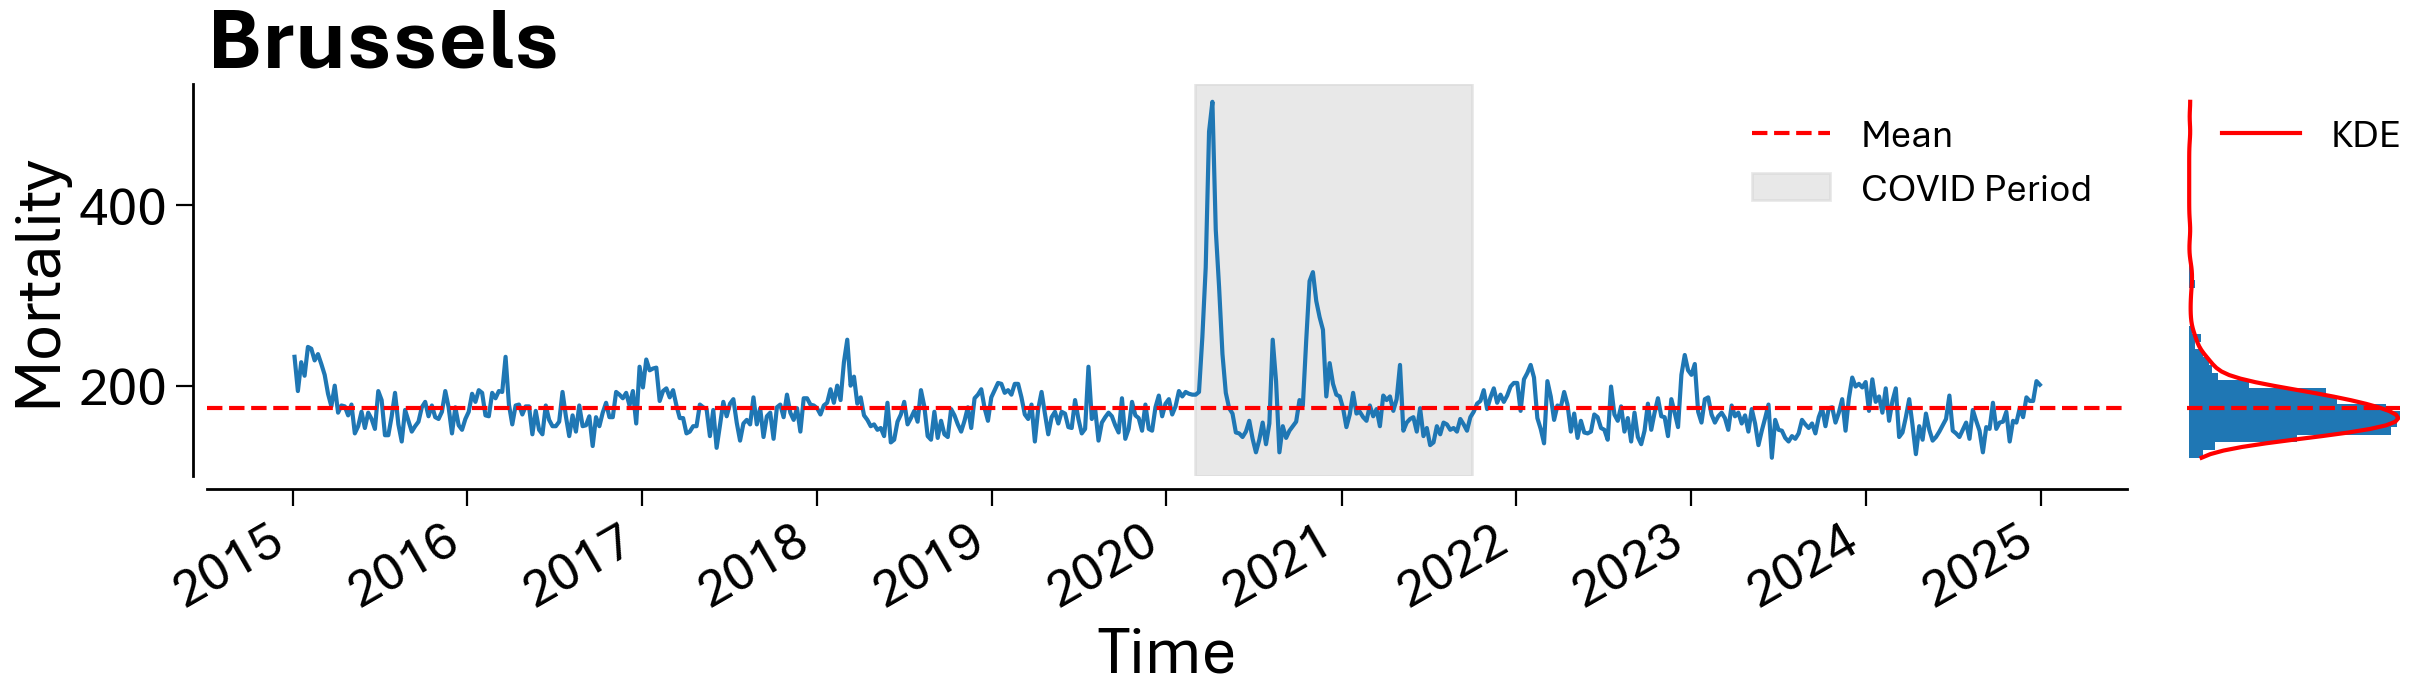

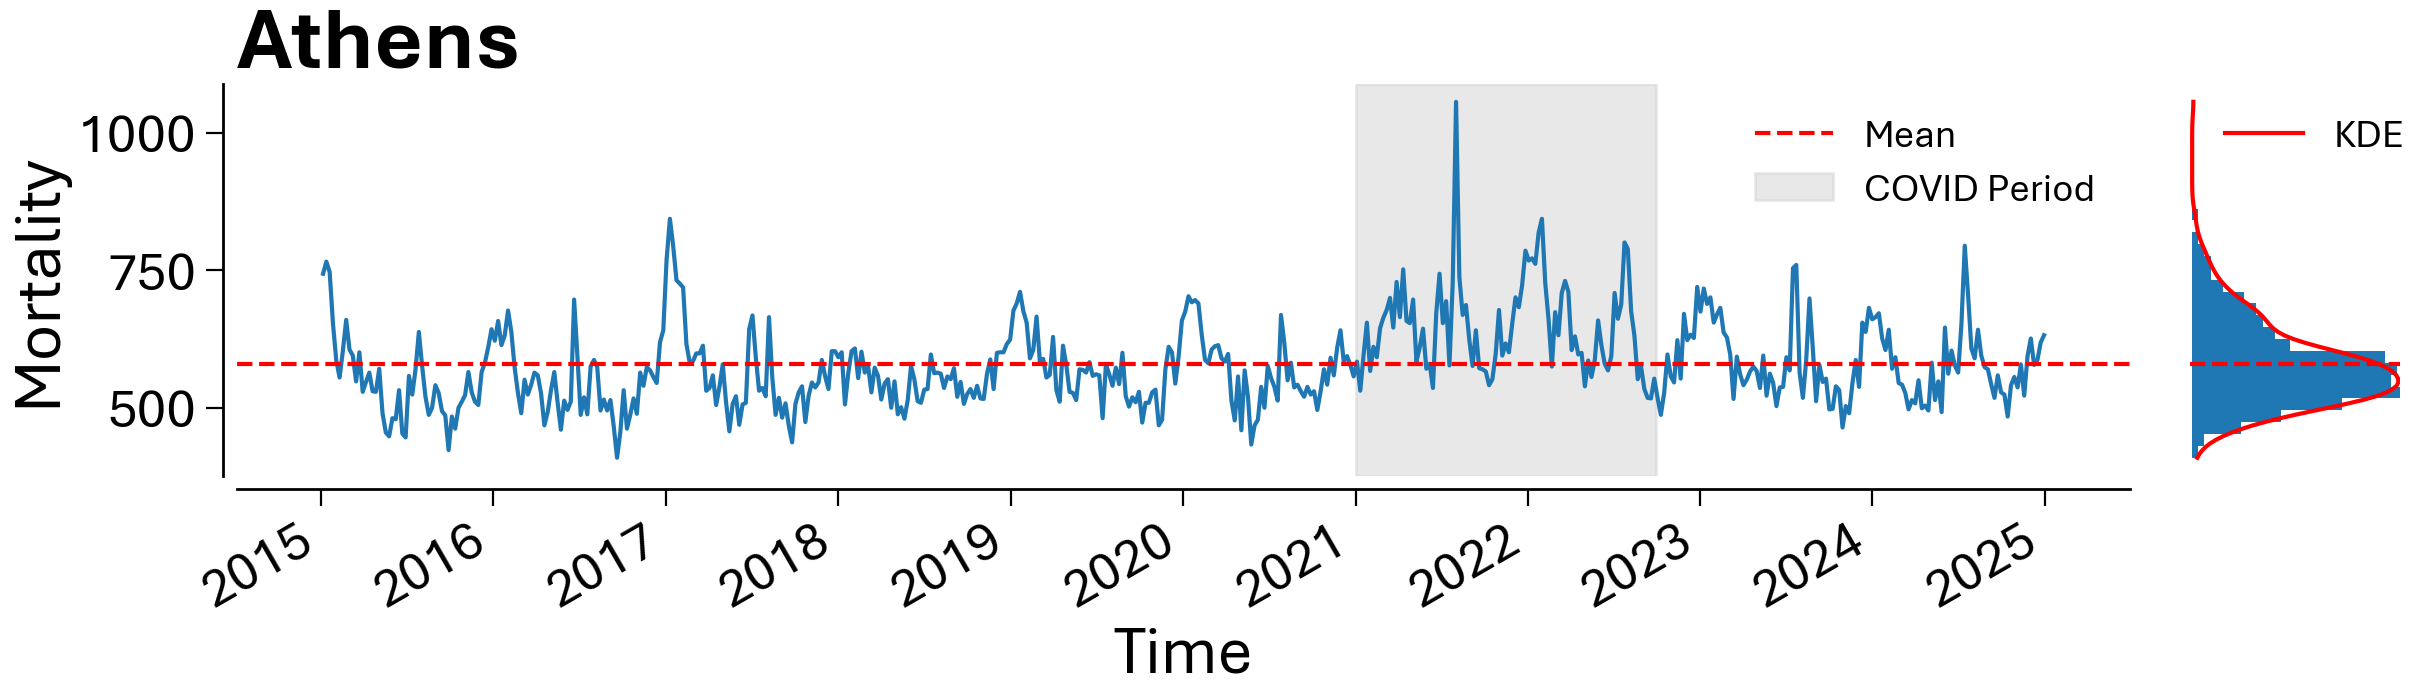

In [4]:
ts_brussels = df_mortality['Brussels']
ts_athens = df_mortality['Athens']

# Plot for Brussels with highlighted COVID period
fig, (ax1, ax2) = ts_dist_plot(ts_brussels, figsize=(12.8, 3.6),
                               moments=['mean'])
_ = ax1.set_ylabel('Mortality')
_ = ax1.set_title('Brussels', loc='left')

covid_start, covid_end = COVID_WINDOWS['Brussels']
ax1.axvspan(pd.to_datetime(covid_start), pd.to_datetime(covid_end),
            color='lightgrey', alpha=0.5, label='COVID Period')
_ = ax1.legend()

# Plot for Athens with highlighted COVID period
fig, (ax1, ax2) = ts_dist_plot(ts_athens, figsize=(12.8, 3.6), moments=['mean'])
_ = ax1.set_ylabel('Mortality')
_ = ax1.set_title('Athens', loc='left')

covid_start, covid_end = COVID_WINDOWS['Athens']
ax1.axvspan(pd.to_datetime(covid_start), pd.to_datetime(covid_end),
            color='lightgrey', alpha=0.5, label='COVID Period')
_ = ax1.legend()


## Percentile-based Excess Mortality

95th Percentile value: 224.0


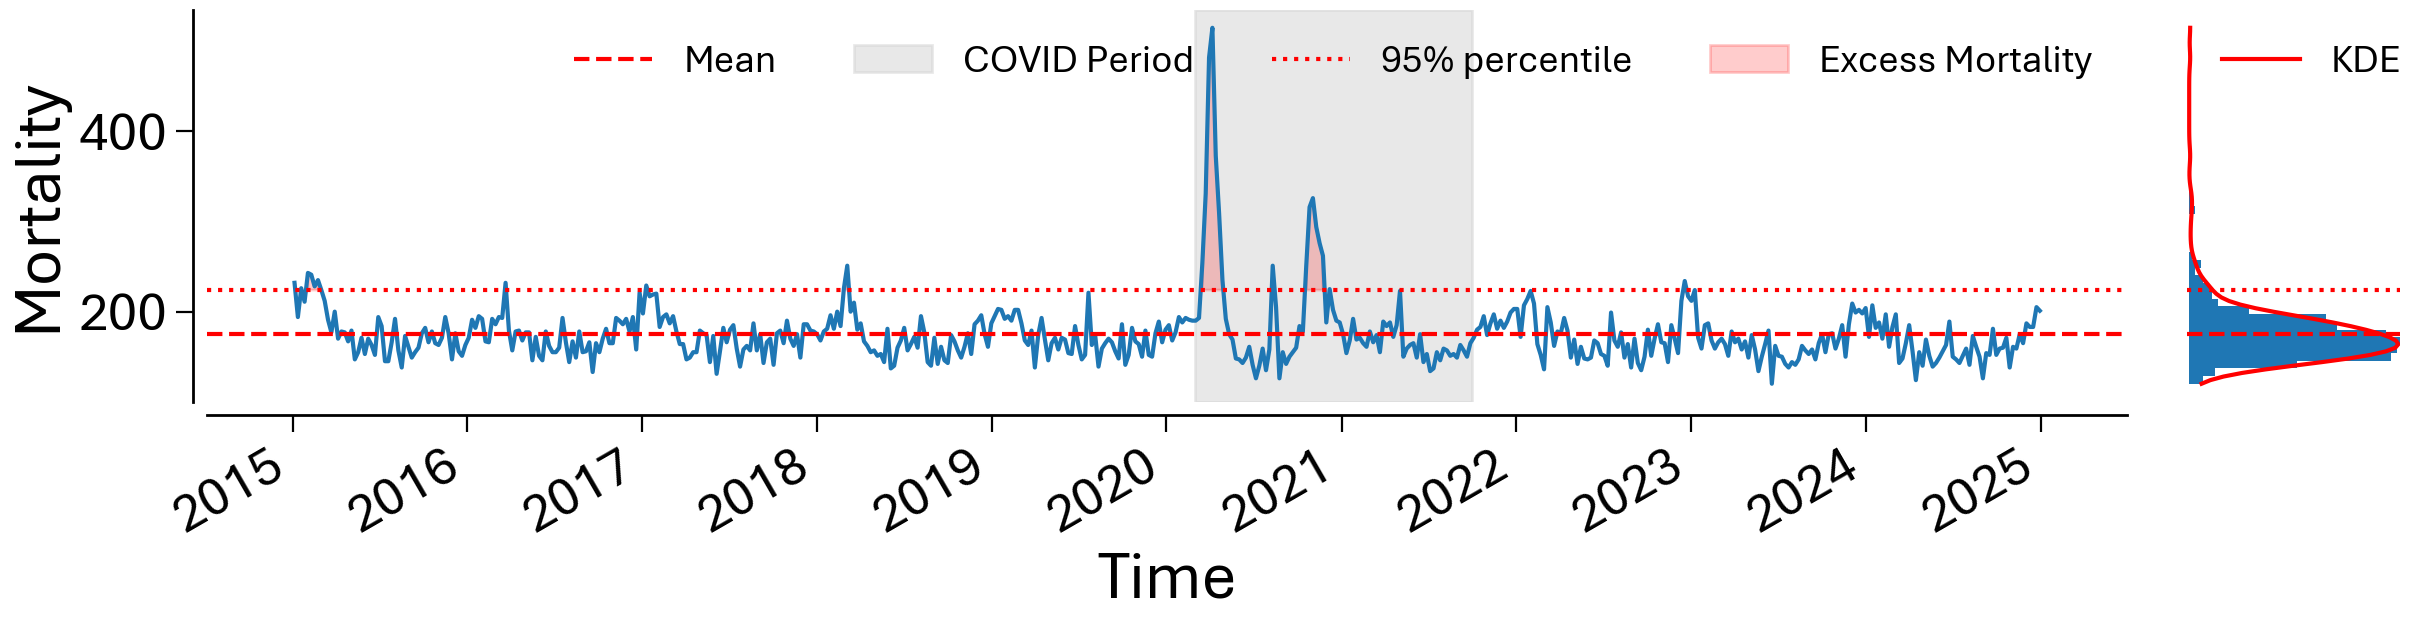

In [5]:
ts = ts_brussels
covid_start, covid_end = COVID_WINDOWS['Brussels']
percentile = 95
percentile_value = ts.quantile(percentile / 100)
print(f'{percentile}th Percentile value: {percentile_value}')

fig, (ax1, ax2) = ts_dist_plot(ts, figsize=(12.8, 3.6), moments=['mean'])
_ = ax1.set_ylabel('Mortality')

ax1.axvspan(pd.to_datetime(covid_start), pd.to_datetime(covid_end),
            color='lightgrey', alpha=0.5, label='COVID Period')

for ax in [ax1, ax2]:
    ax.axhline(percentile_value, color='red', linestyle=':', label=f'{percentile}% percentile')

event_labels, num_event = label(ts > ts.quantile(percentile / 100))
ax1.fill_between(ts.index, percentile_value, ts, where=event_labels > 0,
                 color='red', alpha=0.2, label='Excess Mortality')
_ = ax1.legend(ncol=4)

In [6]:
event_labels, num_event = label(ts > ts.quantile(percentile / 100))
df_events = extract_mortality_events(
    timeseries=ts,
    label=event_labels,
    num_segments=num_event,
    threshold=percentile_value
)
df_events

,mortality,duration,start_week,end_week,threshold,excess_mortality
id,,,,,,
1,[232.0],1,2015-01-05,2015-01-05,224.0,[8.0]
2,[226.0],1,2015-01-19,2015-01-19,224.0,[2.0]
3,"[243.0, 241.0, 228.0, 235.0]",4,2015-02-02,2015-02-23,224.0,"[19.0, 17.0, 4.0, 11.0]"
4,[232.0],1,2016-03-21,2016-03-21,224.0,[8.0]
5,[229.0],1,2017-01-09,2017-01-09,224.0,[5.0]
6,"[226.0, 251.0]",2,2018-02-26,2018-03-05,224.0,"[2.0, 27.0]"
7,"[254.0, 331.0, 482.0, 515.0, 373.0, 309.0, 235.0]",7,2020-03-16,2020-04-27,224.0,"[30.0, 107.0, 258.0, 291.0, 149.0, 85.0, 11.0]"
8,[251.0],1,2020-08-10,2020-08-10,224.0,[27.0]
9,"[250.0, 316.0, 326.0, 294.0, 276.0, 262.0]",6,2020-10-19,2020-11-23,224.0,"[26.0, 92.0, 102.0, 70.0, 52.0, 38.0]"


## Z-score-based Excess Mortality

### Normal distribution

![normal standardized distribution](https://upload.wikimedia.org/wikipedia/commons/2/25/The_Normal_Distribution.svg)

### Procedure

1. Rescale the data distribution to a normal centred reduced distribution
2. Reverse transform the data
3. Segment time series and calculate the excess mortality

### Step 1 data transformation

* We apply the Yeo_Johnson power tranform

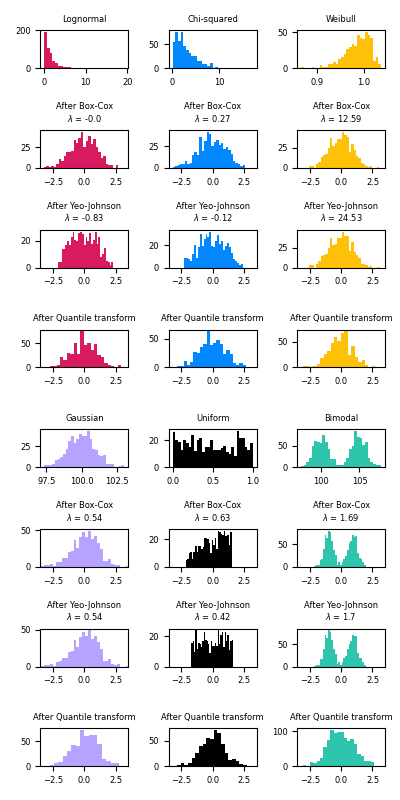


See: https://scikit-learn.org/stable/modules/preprocessing.html#mapping-to-a-gaussian-distribution

In [7]:
from sklearn.preprocessing import PowerTransformer

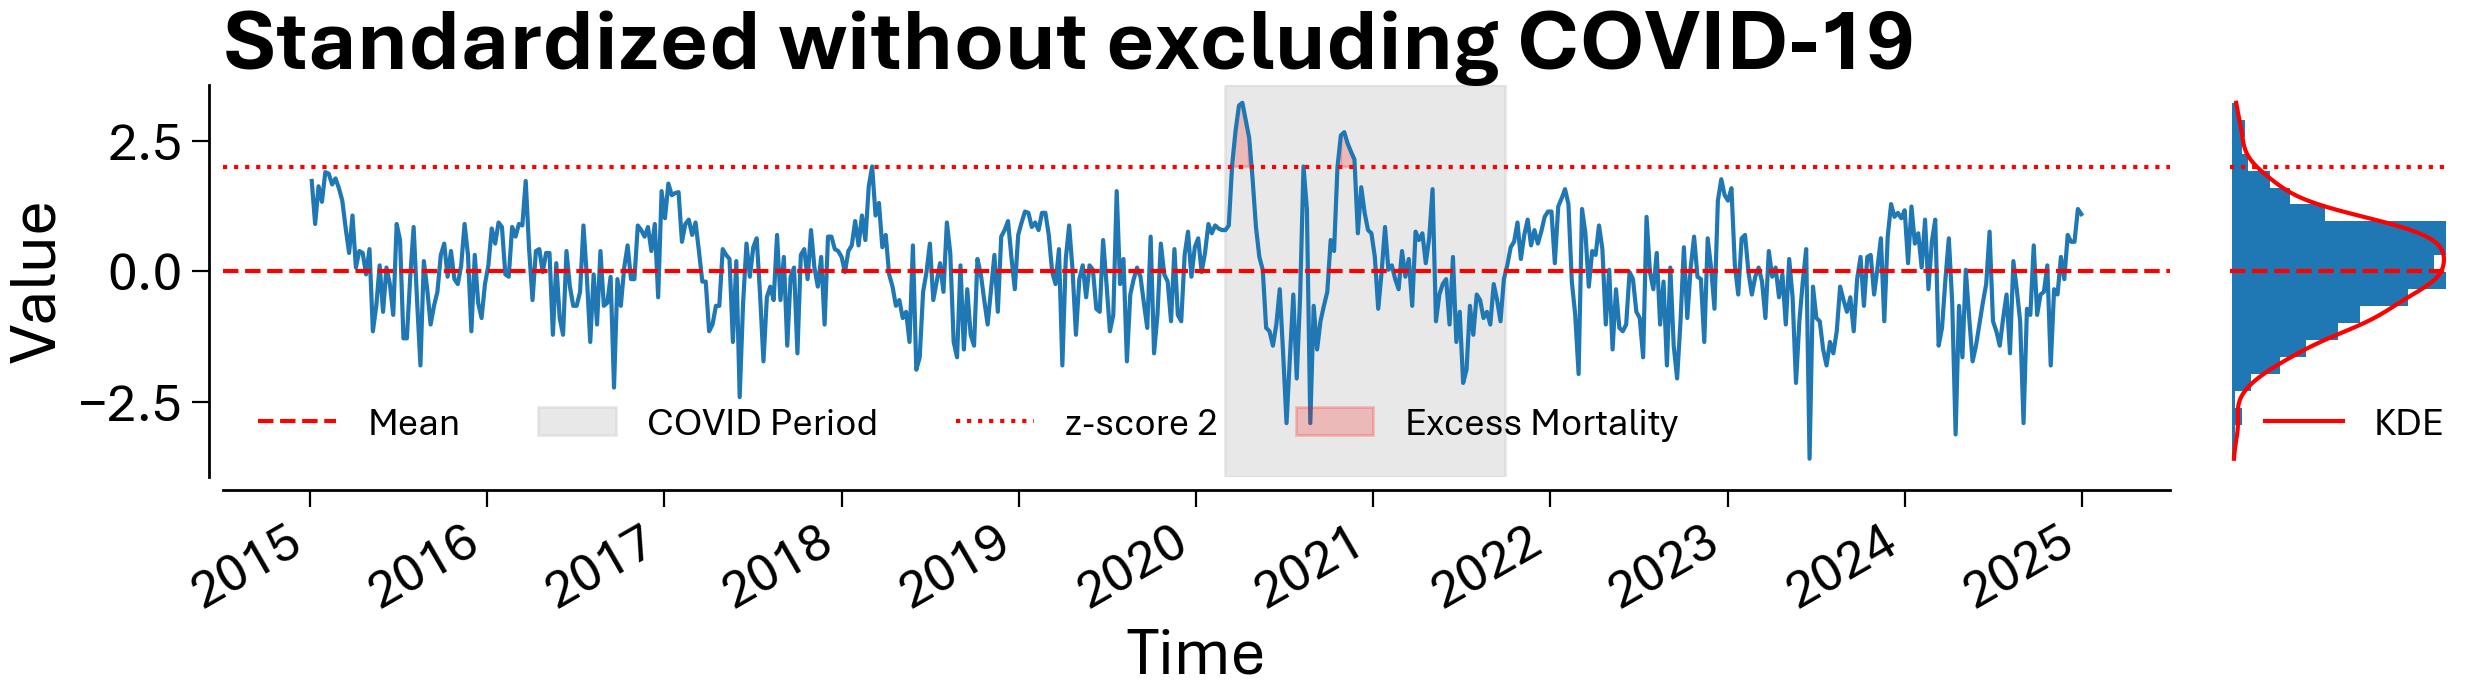

In [8]:
ts = df_mortality['Brussels']
covid_start, covid_end = COVID_WINDOWS['Brussels']

threshold = 2 #  z-score
transformer = PowerTransformer() # Yeo_Johnson by default

ts_transformed = pd.Series(
    index=ts.index,
    data = transformer.fit_transform(ts.values.reshape(-1, 1)).squeeze()
)

fig, (ax1, ax2) = ts_dist_plot(ts_transformed, figsize=(12.8, 3.6), moments=['mean'])
ax1.axvspan(pd.to_datetime(covid_start), pd.to_datetime(covid_end),
            color='lightgrey', alpha=0.5, label='COVID Period')

for ax in [ax1, ax2]:
    ax.axhline(threshold, color='red', linestyle=':', label=f'z-score {threshold}')

event_labels, num_event = label(ts_transformed > threshold)
ax1.fill_between(ts_transformed.index, threshold, ts_transformed, where=event_labels > 0,
                 color='red', alpha=0.2, label='Excess Mortality')
ax1.set_title('Standardized without excluding COVID-19', loc='left')
_ = ax1.legend(ncol=4)

The inverse threshold deaths is significantly high and influenced the peak mortality observed during the COVID-19 pandemic. To account for this anomaly and exclude the impact of COVID-19 from the data transformation process, we can filter out the periods affected by the pandemic. This ensures that the threshold and results reflect normal conditions, removing the exceptional influence of COVID-19.

To exclude COVID-19 data:
- Identify and remove the timeframes associated with the COVID-19 pandemic (e.g., March 2020 to December 2021 in most regions).
- Recompute the data transformation and thresholds without those periods to get a more representative baseline for excess mortality analysis.


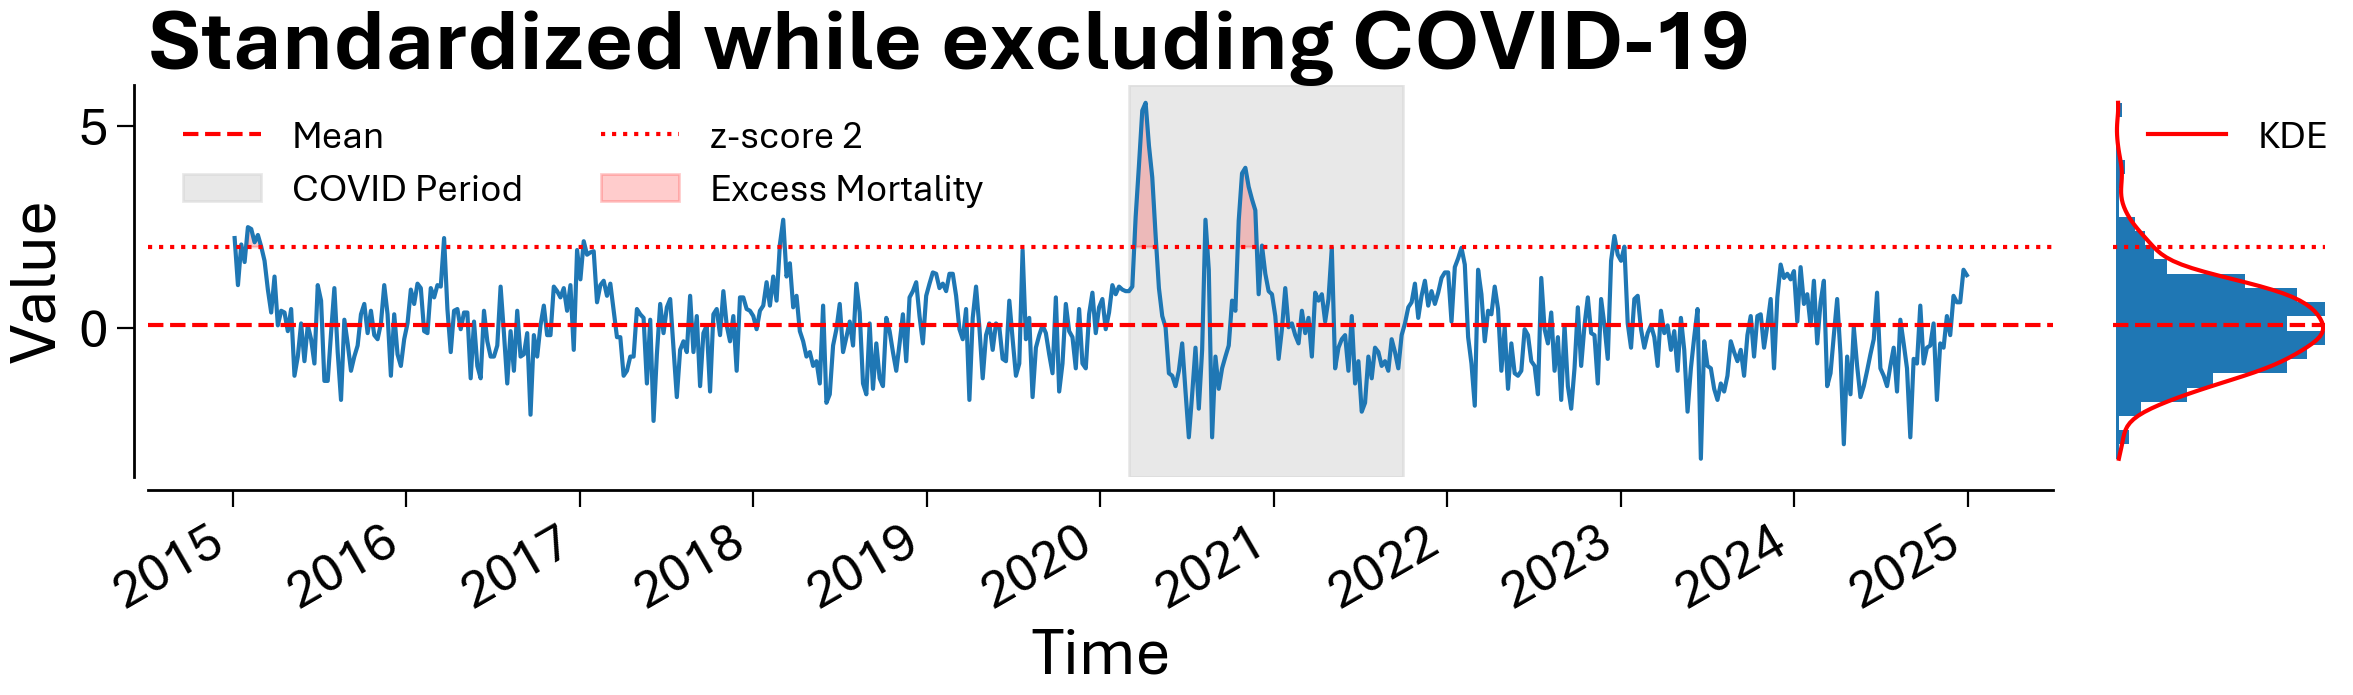

In [9]:
threshold = 2 #  z-score

ts_no_covid = ts.loc[~((ts.index >= '2020-03-01') & (ts.index <= '2021-12-31'))]
transformer = PowerTransformer()
transformer.fit(ts_no_covid.values.reshape(-1, 1))
ts_transformed = pd.Series(
    index=ts.index,
    data = transformer.transform(ts.values.reshape(-1, 1)).squeeze()
)

fig, (ax1, ax2) = ts_dist_plot(ts_transformed, figsize=(12.8, 3.6), moments=['mean'])
ax1.axvspan(pd.to_datetime(covid_start), pd.to_datetime(covid_end),
            color='lightgrey', alpha=0.5, label='COVID Period')

for ax in [ax1, ax2]:
    ax.axhline(threshold, color='red', linestyle=':', label=f'z-score {threshold}')

event_labels, num_event = label(ts_transformed > threshold)
ax1.fill_between(ts_transformed.index, threshold, ts_transformed, where=event_labels > 0,
                 color='red', alpha=0.2, label='Excess Mortality')
ax1.set_title('Standardized while excluding COVID-19', loc='left')
_ = ax1.legend(ncol=2)

### Step 2 inverse transformation

Inversed z-score 2: 223.71


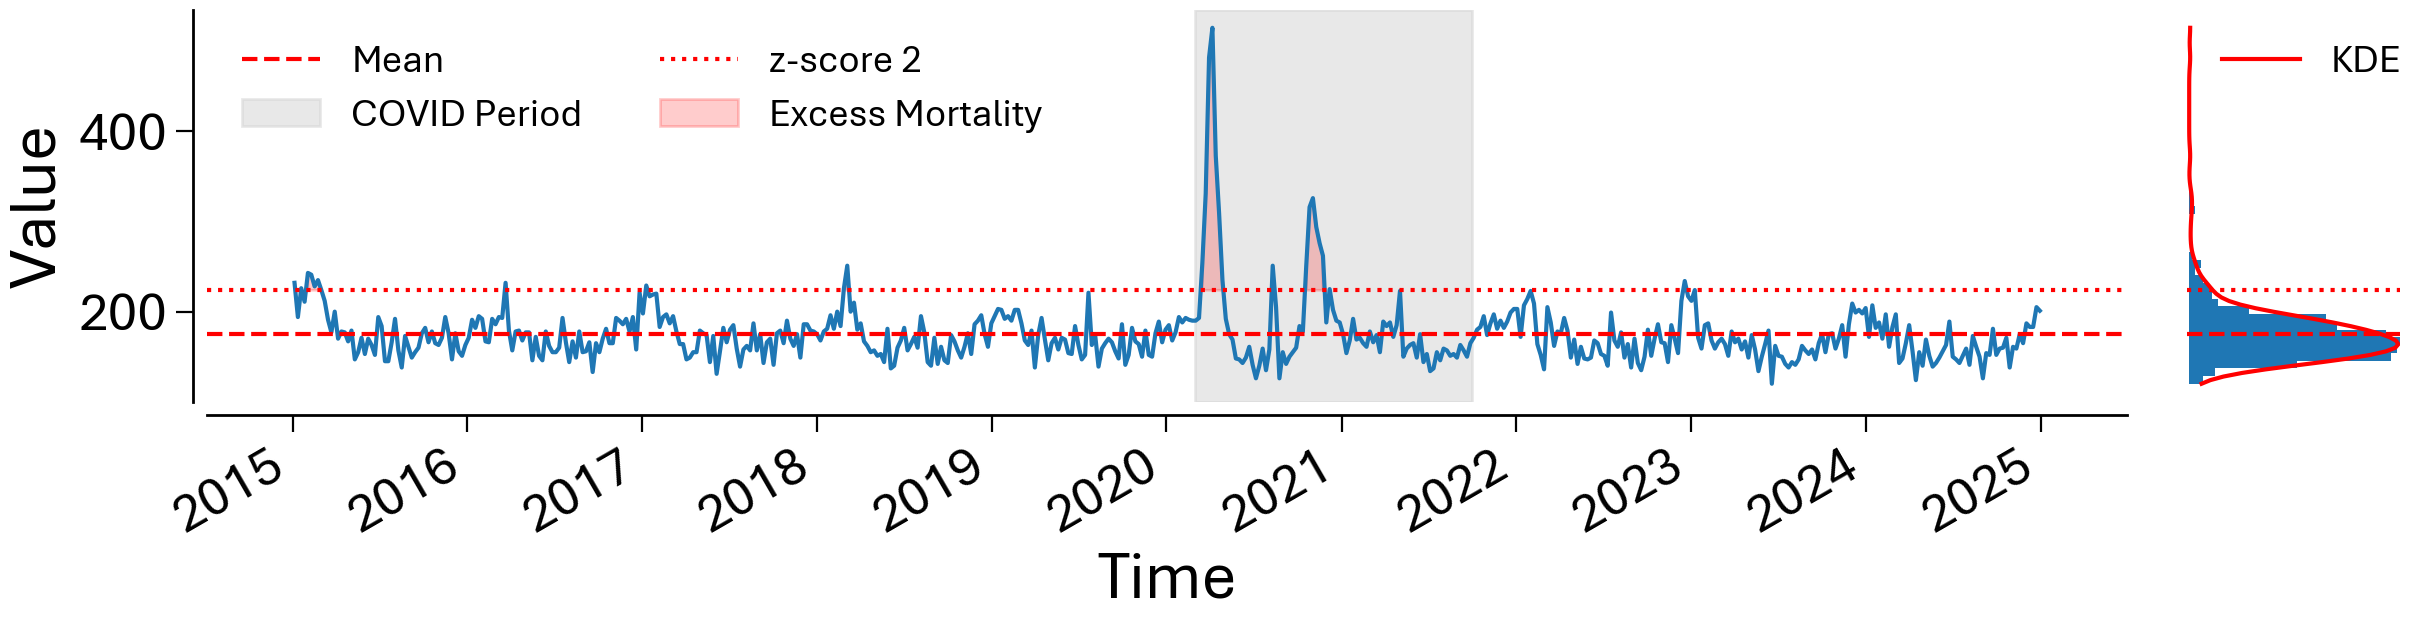

In [10]:
threshold_inverse = transformer.inverse_transform([[threshold]]).squeeze()
print(f"Inversed z-score {threshold}: {threshold_inverse:.2f}")

fig, (ax1, ax2) = ts_dist_plot(ts, figsize=(12.8, 3.6), moments=['mean'])
ax1.axvspan(pd.to_datetime(covid_start), pd.to_datetime(covid_end),
            color='lightgrey', alpha=0.5, label='COVID Period')

for ax in [ax1, ax2]:
    ax.axhline(threshold_inverse, color='red', linestyle=':', label=f'z-score {threshold}')

event_labels, num_event = label(ts > threshold_inverse)
ax1.fill_between(ts.index, threshold_inverse, ts, where=event_labels > 0,
                 color='red', alpha=0.2, label='Excess Mortality')

_ = ax1.legend(ncol=2, loc='upper left')

* All excess mortality modeling approaches face challenges when dealing with outliers, such as those caused by unprecedented events like the COVID-19 pandemic.
* These anomalies can significantly skew results, highlighting the need for careful data handling and preprocessing to mitigate their impact.

In particular,
* Threshold-based methodologies, including percentile and z-score approaches, also have inherent limitations.
* While they are useful for identifying deviations from normal patterns, they do not inherently account for underlying trends or seasonal variations in the data.
* Working on mortality rate time series may reduce observed trends in the data, but not necessarily eliminate them.
* Seasonality favors excess mortality events for specific periods during the year (e.g., winter months).


## GLM Baseline with Log Link and Seasonal Terms

We now estimate a baseline using a generalized linear model (GLM) with:

- log link function
- a distribution that can account for overdispersion (Negative Binomial)
- a linear time trend
- annual seasonal terms using sine and cosine (first harmonic)

We fit the model on pre‑COVID (and post initial COVID wave) weeks to avoid the pandemic peak biasing the baseline, and then predict the baseline for the full period.

Optimization terminated successfully.
         Current function value: 4.277538
         Iterations: 17
         Function evaluations: 28
         Gradient evaluations: 28


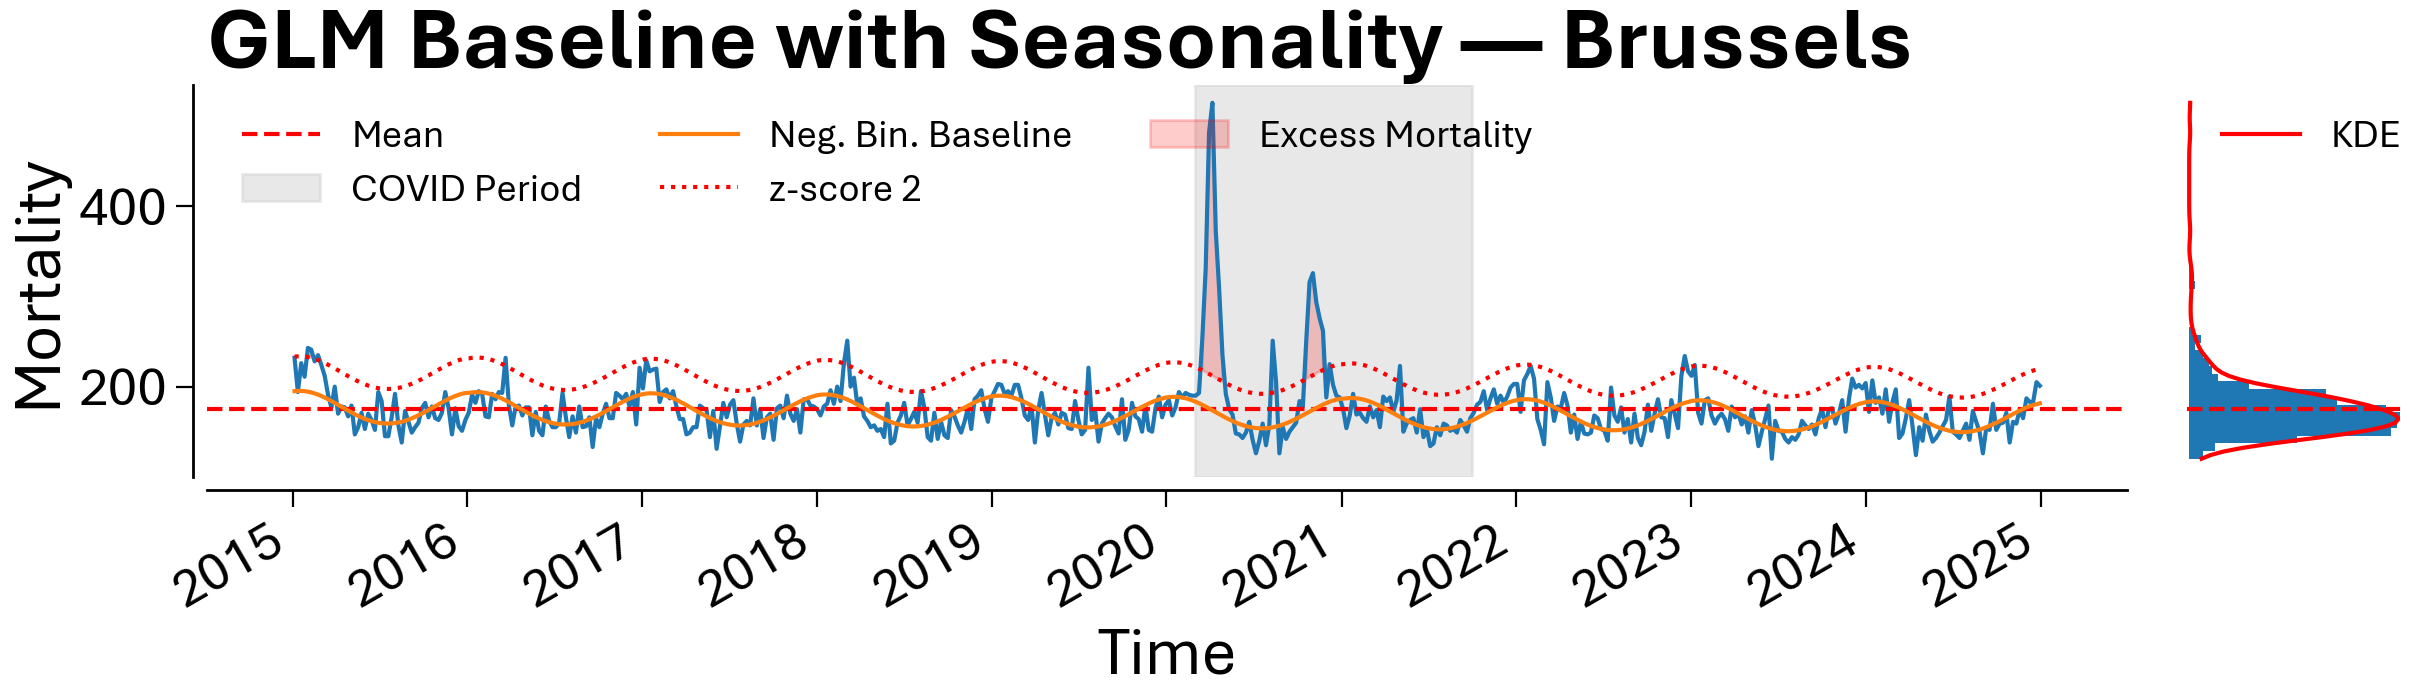

In [11]:
import statsmodels.api as sm

# Select a city to model
ts = ts_brussels
covid_start, covid_end = COVID_WINDOWS['Brussels']

# Build design matrix with linear trend and seasonal (annual) sine/cosine terms
# Extract ISO week of year; handle as integer in [1, 53]
week_of_year = ts.index.isocalendar().week.astype(int)
# Some years have week 53; use 52.1775 (~avg weeks/year) to smooth across calendars
omega = 2 * np.pi * (week_of_year / 52.1775)

X = pd.DataFrame({
    't': np.arange(len(ts), dtype=float),
    'sin1': np.sin(omega.values),
    'cos1': np.cos(omega.values),
}, index=ts.index)
X = sm.add_constant(X, has_constant='add')

# Training mask to exclude main COVID period from fitting
train_mask = ~((ts.index >= covid_start) & (ts.index <= covid_end))
ts_no_covid = ts[train_mask]

# Fit GLM with Negative Binomial family (log link)
model_nb = sm.NegativeBinomial(
    ts_no_covid.values,
    X.loc[train_mask, :].values,)
res_nb = model_nb.fit()

# Predict baseline (expected mean mu_hat) for the full period
mu_hat = pd.Series(res_nb.predict(X.values), index=ts.index, name='baseline_nb')

# Compute residuals and z-score 2 envelope (same as before)
threshold = 2
residuals = ts - mu_hat
residuals_no_covid = residuals.loc[~((ts.index >= '2020-03-01') & (ts.index <= '2021-12-31'))]
transformer = PowerTransformer()
transformer.fit(residuals_no_covid.values.reshape(-1, 1))

threshold_inverse = transformer.inverse_transform([[threshold]]).squeeze()
z2_limit = mu_hat + threshold_inverse

# Plot observed vs GLM baseline and residuals distribution
fig, (ax1, ax2) = ts_dist_plot(ts, figsize=(12.8, 3.6), moments=['mean'])
ax1.axvspan(pd.to_datetime(covid_start), pd.to_datetime(covid_end),
            color='lightgrey', alpha=0.5, label='COVID Period')

ax1.plot(mu_hat.index, mu_hat.values, color='tab:orange', label='Neg. Bin. Baseline')
ax1.set_ylabel('Mortality')
ax1.set_title(f'GLM Baseline with Seasonality — {ts.name}', loc='left')

# Plot z-score envelope and excess mortality events
ax1.plot(z2_limit, color='red', linestyle=':', label=f'z-score {threshold}')
event_labels, num_event = label(ts > z2_limit)
ax1.fill_between(ts.index, z2_limit, ts, where=event_labels > 0,
                 color='red', alpha=0.2, label='Excess Mortality')

_ = ax1.legend(ncol=3, loc='upper left')